# 1. Import


In [440]:
# 1.1 Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state

# 1.2 read data and split it into features and targets
data = pd.read_csv("../data/processedWineData.csv")
X, y = data.loc[:, data.columns != 'quality'], data.loc[:, data.columns == 'quality']


# 2. Check Feature Importance

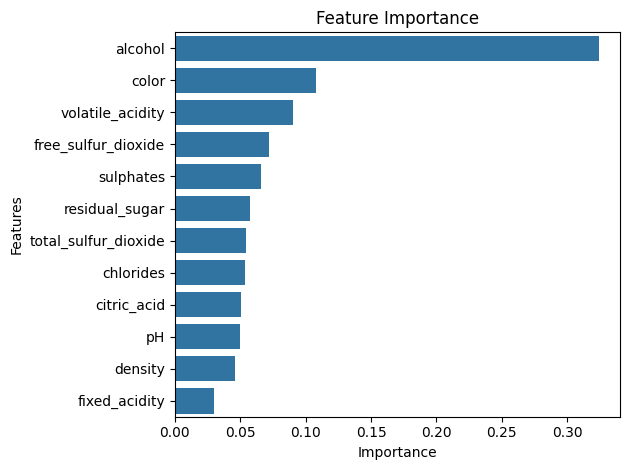

In [441]:
test_model = xgb.XGBRegressor()
test_model.fit(X, y)

importances=test_model.feature_importances_

# Plot the features importance using a barplot
feature_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.tight_layout()

It shows the importance of alcohol is much higher than the other features, follows by color and volatile acidity.

# 3 Data Handling

In [442]:
# 3.1 Split data into training, validation and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=9)

# 3.2 Convert the data into DMatrix, which is a data storage used by XGBoost Algorithm, optimized for both memory efficiency and training speed
D_train = xgb.DMatrix(X_train, label=y_train)
# D_val = xgb.DMatrix(X_val, label=y_val)
D_test = xgb.DMatrix(X_test, label=y_test)

In [456]:
# Perform hyperparameter grid search to tune the hyperparameter

# Define the set of hyperparameters to tune

def custom_objective(y_true, y_pred):
    # Penalize the model for non-integer predictions
    # You can define your own penalty function here
    # return np.mean(abs(y_true - np.round(y_pred))**2)
    return np.mean((y_true - np.round(y_pred))**2 + abs(np.round(y_pred)-y_true))

pipeline = Pipeline([
    ('selector', SelectFromModel(estimator=xgb.XGBRegressor(random_state=9), threshold=-np.inf)),
    #('regressor', xgb.XGBRegressor(objective=custom_objective))
    ('regressor', xgb.XGBRegressor(objective='reg:squaredlogerror'))
])

model = xgb.XGBRegressor()
parameters = {
              'nthread':[-1],
              'base_score': [7],
              'learning_rate': [0.08, 0.1, 0.12], #so called `eta` value
              'max_depth': [6, 7, 8],
              'min_child_weight': [6, 7, 8],
              'gamma': [0.2, 0.25],
              'subsample': [0.7],
              'colsample_bytree': [0.6],
              'n_estimators': [95],
              'lambda': [0.5, 0.55, 0.6],
              'alpha': [0.5, 0.6, 0.7]
              }

test_param = {
        'base_score': [6.5], 
        'colsample_bytree': [0.65], 
        'gamma': [0.5], 
        'learning_rate': [0.05], 
        'max_depth': [13], 
        'min_child_weight': [6], 
        'n_estimators': [75], 
        'nthread': [-1], 
        'subsample': [0.6]
        }

xgb_grid = GridSearchCV(model, parameters, cv = 10, n_jobs = -1, verbose=True)

# Fit the grid search
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

# train(..., evals=evals, early_stopping_rounds=10)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


In [ ]:
# Display the best hyperparameter combination from Grid Search
xgb_best_params = xgb_grid.best_params_

# Display the best hyperparameter combination from the loaded model
# loaded_params = xgb_pipeline.get_params()
# xgb_best_params = {}
# for param, value in loaded_params.items():
#     if param in ['classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__n_estimators', 'feature_selection__estimator__bootstrap']:
#         xgb_best_params[param] = value
# print("The best hyperparameter combination is: ", xgb_best_params)

# Refit the XGBoost classifier with the best hyperparameters
model.set_params(**xgb_best_params)
model.fit(X_train, y_train.values.reshape(len(y_train),))

# predict training set
xgb_y_pred_tmp = model.predict(X_train)

# Accuracy Score
rounded_xgb_y_pred_tmp = np.round(xgb_y_pred_tmp).astype(int)
# balanced_accuracy_score
print("Training set Accuracy: {}".format(accuracy_score(y_train, rounded_xgb_y_pred_tmp)))

# Make predictions using the XGBoost classifier
xgb_y_pred = model.predict(X_test)

rounded_xgb_y_pred = np.round(xgb_y_pred).astype(int)

# Accuracy Score
print("Testing set Accuracy: {}".format(accuracy_score(y_test, rounded_xgb_y_pred)))

Training set Accuracy: 0.7472040107983031
Testing set Accuracy: 0.6006168080185043


In [ ]:
compare_classes = np.vstack([np.array(y_test).T, xgb_y_pred.round()]).T
df = pd.DataFrame(data=compare_classes, columns=["true_label", "predicted_label"])
df.groupby(["true_label", "predicted_label"]).size()

true_label  predicted_label
3.0         5.0                  4
            6.0                  4
            7.0                  1
4.0         4.0                  1
            5.0                 27
            6.0                 12
5.0         4.0                  1
            5.0                260
            6.0                158
            7.0                  4
6.0         5.0                100
            6.0                395
            7.0                 43
7.0         5.0                  6
            6.0                121
            7.0                122
8.0         6.0                  9
            7.0                 28
            8.0                  1
dtype: int64

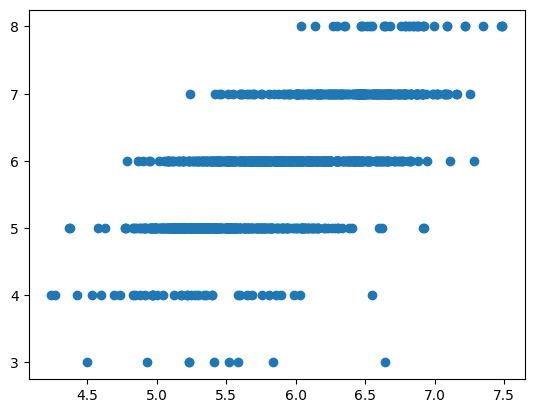

In [446]:
plt.scatter(xgb_y_pred, y_test)

In [203]:
# Perform hyperparameter grid search to tune the hyperparameter

# Define the set of hyperparameters to tune


pipeline = Pipeline([
    ('selector', SelectFromModel(estimator=xgb.XGBClassifier(n_estimators=100, random_state=9), threshold=-np.inf)),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

# model = xgb.XGBRegressor()
parameters = {'nthread':[-1], 
              'base_score': [6],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [6, 9, 11],
              'min_child_weight': [2, 4, 6],
              'subsample': [0.6, 0.7, 0.8],
              'colsample_bytree': [0.6, 0.70, 0.80],
              'n_estimators': [50, 100, 150, 200]
              }

# xgb_grid.fit(X_train, y_train)

pipeline.fit(X, y)

selected_features = pipeline['selector'].get_support()

# Print selected features
print("Selected Features For XGBoost:")
for feature, selected in zip(X.columns, selected_features):
    if selected:
        print(feature)


selected_features_importances = pipeline['selector'].estimator_.feature_importances_[selected_features]
print(selected_features_importances)
# [0.09361505 0.18474296 0.14420615 0.01952794 0.10946904 0.02192107 0.03307951 0.02948984 0.02851948 0.1216883]

selected_features_coefficients = pipeline['regressor'].coef_
print(selected_features_coefficients)

def custom_objective(y_true, y_pred):
    # Penalize the model for non-integer predictions
    # You can define your own penalty function here
    return np.mean(np.abs(y_true - np.round(y_pred)))

xgb_grid_search = GridSearchCV(pipeline, parameters, cv = 5, n_jobs = -1, verbose=True)

xgb_grid_search.fit(X_train, y_train.values.reshape(len(y_train),))
# train(..., evals=evals, early_stopping_rounds=10)



Selected Features For XGBoost:
fixed_acidity
volatile_acidity
citric_acid
residual_sugar
chlorides
free_sulfur_dioxide
total_sulfur_dioxide
density
pH
sulphates
alcohol
color
[0.03005941 0.09034853 0.05040714 0.0570967  0.05351682 0.07178234
 0.05414964 0.04577948 0.049408   0.06550036 0.3241697  0.10778195]
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


ValueError: Invalid parameter 'base_score' for estimator Pipeline(steps=[('selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        grow_policy=None,
                                                        importance_type=None,
                                                        interaction_constraints...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
model2 = xgb.XGBRegressor(learning_rate=0.02, n_estimators=100)

model2.fit(X_train, y_train)
model2.best_score_

In [183]:
from sklearn.metrics import mean_squared_error, r2_score

tttrr = xgb.XGBRegressor(learning_rate=0.02, n_estimators=300, objective='reg:squarederror', nthread=-1)

tttrr.fit(X_train, y_train)

predictions = tttrr.predict(X_test)

# Calculate the mean squared error and R-squared score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

rounded_y_pred = np.round(predictions).astype(int)

accuracy_score(rounded_y_pred, y_test)


Mean Squared Error: 0.44241946482592864
R-squared Score: 0.44429693155623884


0.5851966075558982

# 6 Model Construction

In [ ]:
X_test.shape


(1297, 12)

/var/folders/8f/xm08m3255q9b0j33fhp73q_w0000gn/T/ipykernel_23921/2517370342.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y , fit='norm');


AttributeError: 'str' object has no attribute 'fit'

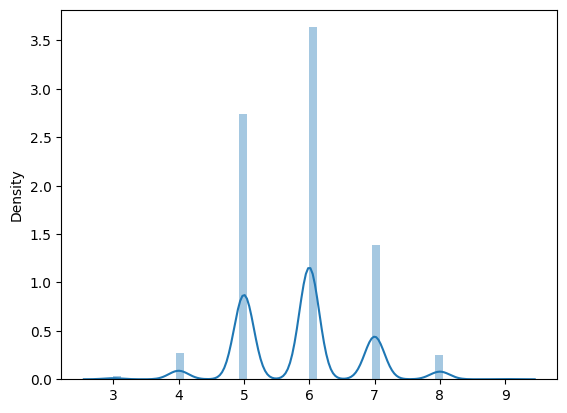

In [181]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

rounded_y_pred = np.round(y_pred).astype(int)

accuracy_score(rounded_y_pred, y_test)

0.525828835774865